In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Project Final Report
**DSCI 100 Group 4: Naijide Anwaer, Maggie Ruan, Yun Xing  
Date: December 05, 2021**


### Introduction 
The purpose of this project proposal is to provide an overview of the rock petrophysical data process project. This proposal introduces the rock properties database, illustrates the exploratory data analysis, explains the methodology, and discusses the expected outcome of this project.  
 
The Canadian Rock Physical Property Database (CRPPD) includes rock petrophysical measurements on over 20,000 observations collected during the last 40 years. The rock measurements available in this database are density, porosity, resistivity etc.. Geographically, observations are categorized into different sample types including outcrop, subcrop, hand sample, and borehole sample. Geologically, observations are categorized into different rock types including igneous, sedimentary, and metamorphic, the three fundamental rock types.  

The group intends to study the relationship between the rock petrophysical measurements and the three fundamental rock types, and to answer a classification problem: given the physical properties data, whether the rock will be igneous, sedimentary, or metamorphic.   

The classifier model will be useful in the situation where the physical property data are available while the rock type is unclassified. An example of this will be in diamond drillholes (sample type: Borehole), where not all the rock core in the borehole are brought up to the surface for visual examination. As a result, the group decided to perform the data analysis with the focus on data categorized under sample type borehole.



### Preliminary Analysis
The preliminary data are obtained as a zip file from the Government of Canada, Natural Resources Canada website. Upon unzipping the file and bringing the original excel file into Jupiter notebook for R processing, the group noticed that R encountered a runtime error.  
 
Indicated by read_* documentation, the column type will be imputed from the first 1000 rows on the input file. As the top 1000 data in this excel mostly contains NULL values, R automatically assigned “col_logical” as the column type for most of the columns. However, this column type conflicts with the majority of the other observations, which contain numerical values.    
 
To solve this issue, the group decides to sort the observations in excel before importing into Jupiter. We relocated the columns with no missing data to the top of the file, and R successfully created columns with the proper type “col_double” and no error was thrown. The following code demonstrates the steps of data import:


In [2]:
url <- "https://raw.githubusercontent.com/yxing6/DSCI_100_Project_Group4/main/data/of_8460_database.csv"
download.file(url, destfile = "rock_physical_properties.csv")
rock_data_raw <- read_csv("rock_physical_properties.csv")
# glimpse(rock_data_all)

Parsed with column specification:
cols(
  .default = col_character(),
  `Date Mapped (yyyy/mm/dd) *` = col_double(),
  `Lat Deg` = col_double(),
  `Long Deg` = col_double(),
  `UTM zone` = col_double(),
  Easting = col_double(),
  Northing = col_double(),
  `Method Precision (m)*` = col_double(),
  `Year *` = col_double(),
  `Lab Date` = col_double(),
  `GRAIN DEN Sample Value [g/cm3]` = col_double(),
  `DRY BULK DEN Sample Value [g/cm3]` = col_double(),
  `SAT BULK DEN Sample Value [g/cm3]` = col_double(),
  `POR Sample Value [%]` = col_double(),
  `MS Sample Value [SI A/m / A/m]` = col_double(),
  `NRM Sample Value [A/m]` = col_double(),
  `KN50 Sample Value` = col_double(),
  `Local Field [uT]` = col_double(),
  KN = col_double(),
  `RES Sample Value [Ohm.m]` = col_double(),
  `CHG Sample Value [ms]` = col_double()
)

See spec(...) for full column specifications.



  
The following codes demonstrate the steps of data cleaning and wrangling into a tidy format:  
  

In [3]:
borehole_data_raw <- rock_data_raw %>% 
    select("Location Type *", "MIRA Master Litho 1", "GRAIN DEN Sample Value [g/cm3]",
           "POR Sample Value [%]","MS Sample Value [SI A/m / A/m]",
           "NRM Sample Value [A/m]","RES Sample Value [Ohm.m]","CHG Sample Value [ms]") %>%
    rename("sample_type" = "Location Type *",
          "lithology" = "MIRA Master Litho 1",
           "density" = "GRAIN DEN Sample Value [g/cm3]",
           "porosity" = "POR Sample Value [%]",
           "MS" = "MS Sample Value [SI A/m / A/m]",
           "NRM" = "NRM Sample Value [A/m]",
           "RES" = "RES Sample Value [Ohm.m]",
           "chargeability" = "CHG Sample Value [ms]") %>%
    mutate(sample_type = as_factor(sample_type),
          lithology = as_factor(lithology)) %>%
    filter(lithology != "Other", sample_type == "Borehole")

borehole_data_raw

# column units:
# density[g/cm3]
# porosity[%]
# MS[m3/kg]
# NRM[A/m]
# RES[Ohm.m]
# chargeability[ms]

#!is.na(col)

# currently omiting all NA data 
# if later on decide on specific predictors, only omit NA on those variables 
# e.g. na.omit(borehole_data[1:3])
borehole_data_unscaled <- na.omit(borehole_data_raw) %>%
    select(-sample_type)

borehole_data_unscaled

sample_type,lithology,density,porosity,MS,NRM,RES,chargeability
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Borehole,Igneous,2.931,0.41,0.00118,0.029,7960,46.4
Borehole,Igneous,2.770,0.28,0.07900,4.810,135000,19.5
Borehole,Igneous,2.754,0.28,0.01260,0.352,51800,1.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Borehole,Metamorphic,2.665,0.08,NA,NA,91800,3.868
Borehole,Metamorphic,2.641,0.09,NA,NA,67800,1.388
Borehole,Metamorphic,2.811,0.36,0.0739,5.72,437000,12.850


lithology,density,porosity,MS,NRM,RES,chargeability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Igneous,2.931,0.41,0.00118,0.029,7960,46.4
Igneous,2.770,0.28,0.07900,4.810,135000,19.5
Igneous,2.754,0.28,0.01260,0.352,51800,1.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Metamorphic,2.660,0.34,-7.08e-06,0.000162,18600,1.015
Metamorphic,2.791,0.16,1.68e-04,0.000401,27100,8.026
Metamorphic,2.811,0.36,7.39e-02,5.720000,437000,12.850



We then split the data into training and testing sets.  
  
Using only the training set, we built a table that consists the mean values of each predictors for each category.  

  

In [4]:
borehole_data_split <- initial_split(borehole_data_unscaled, prop = 0.75, strata = lithology)
data_train <- training(borehole_data_split)
data_test <- testing(borehole_data_split)


# options(repr.plot.width = 15, repr.plot.height = 15)
# train_pairs <- data_train %>%
#     select("density":"chargeability") %>%
#     ggpairs() + 
#     theme(text = element_text(size = 20))
# train_pairs

training_data_prop <- data_train %>%
    group_by(lithology) %>%
    summarize(n = n(), 
              across(density:chargeability, mean, na.rm = TRUE))

training_data_prop <- training_data_prop %>%
                    rename("lithology" = "lithology",
                            "n" = "n",
                            "mean_Density[g/cm3]" = "density",
                            "mean_Porosity[%]" = "porosity",
                            "mean_MS[m3/kg]" = "MS",
                            "mean_NRM[A/m]" = "NRM",
                            "mean_RES[Ohm.m]" = "RES",
                            "mean_Chargeability[ms]" = "chargeability")

training_data_prop

# unbalanced data 

`summarise()` ungrouping output (override with `.groups` argument)



lithology,n,mean_Density[g/cm3],mean_Porosity[%],mean_MS[m3/kg],mean_NRM[A/m],mean_RES[Ohm.m],mean_Chargeability[ms]
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Igneous,213,2.805258,2.2292958,0.022633525,1.33363195,13261.170,11.572268
Metamorphic,559,2.770982,0.4470483,0.001708148,0.52407663,9808.564,5.686354
Sedimentary,141,2.657965,5.8538298,0.000232826,0.02095233,3736.071,3.906858


In [5]:
# balance and upsample

# library(themis)



# Trevor: tansfrom the predictors showing huge range into log scale before any recipe steps 
# save to do so for all data
# check if there is any built in log special step in recipe? 

# do you need to upsample? it is not super unbalanced 
# use cross-validation to compare K = 1, 2, 3, ... 
# then compare accuracy on the data without upsample and with upsample, see if upsample really improve the result. 

training_data_recipe <- recipe(lithology ~ ., data = data_train) %>%
     step_upsample(lithology, over_ratio = 1, skip = FALSE) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors()) %>%
#      step_upsample(lithology, over_ratio = 1, skip = FALSE) %>%
     prep()


training_data_recipe

training_data_good_to_go <- training_data_recipe %>%
    bake(data_train) %>%
    filter(!is.na(lithology))

training_data_good_to_go

# options(repr.plot.width = 15, repr.plot.height = 15)
# train_pairs <- training_data_good_to_go %>%
#     select("density":"chargeability") %>%
#     ggpairs() + 
#     theme(text = element_text(size = 20))
# train_pairs

training_data_good_to_go %>% 
    group_by(lithology) %>%
    summarize(n = n())

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Training data contained 913 data points and no missing data.

Operations:

Up-sampling based on lithology [trained]
Scaling for density, porosity, MS, NRM, RES, chargeability [trained]
Centering for density, porosity, MS, NRM, RES, chargeability [trained]

density,porosity,MS,NRM,RES,chargeability,lithology
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.2656875,-0.5765318,0.2861323,0.03476043,0.04587806,0.2353382,Igneous
-0.6955624,-0.5922016,-0.1914589,-0.16515415,0.57006621,-0.5064278,Igneous
-0.1841595,0.4002206,2.0203852,0.87938346,-0.27537915,0.7896249,Igneous
⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.7474438,-0.4015521,-0.24751613,-0.18153498,-0.2449295,-0.4946899,Sedimentary
0.2383038,2.1212896,-0.23133773,-0.17310629,-0.2841935,-0.4640411,Sedimentary
-0.6140344,-0.2500771,0.01689028,0.02218903,-0.2820233,-0.1803768,Sedimentary


`summarise()` ungrouping output (override with `.groups` argument)



lithology,n
<fct>,<int>
Igneous,559
Metamorphic,559
Sedimentary,559


  
In the next step, we visualized the data in a scatter plot of resistivity vs porosity as predictors and colored the rock categories.  

density,porosity,MS,NRM,RES,chargeability,lithology
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.2656875,-0.5765318,0.2861323,0.03476043,0.04587806,0.2353382,Igneous
-0.6955624,-0.5922016,-0.1914589,-0.16515415,0.57006621,-0.5064278,Igneous
-0.1841595,0.4002206,2.0203852,0.87938346,-0.27537915,0.7896249,Igneous
⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.7474438,-0.4015521,-0.24751613,-0.18153498,-0.2449295,-0.4946899,Sedimentary
0.2383038,2.1212896,-0.23133773,-0.17310629,-0.2841935,-0.4640411,Sedimentary
-0.6140344,-0.2500771,0.01689028,0.02218903,-0.2820233,-0.1803768,Sedimentary


Warning message:
“Removed 4 rows containing missing values (geom_point).”


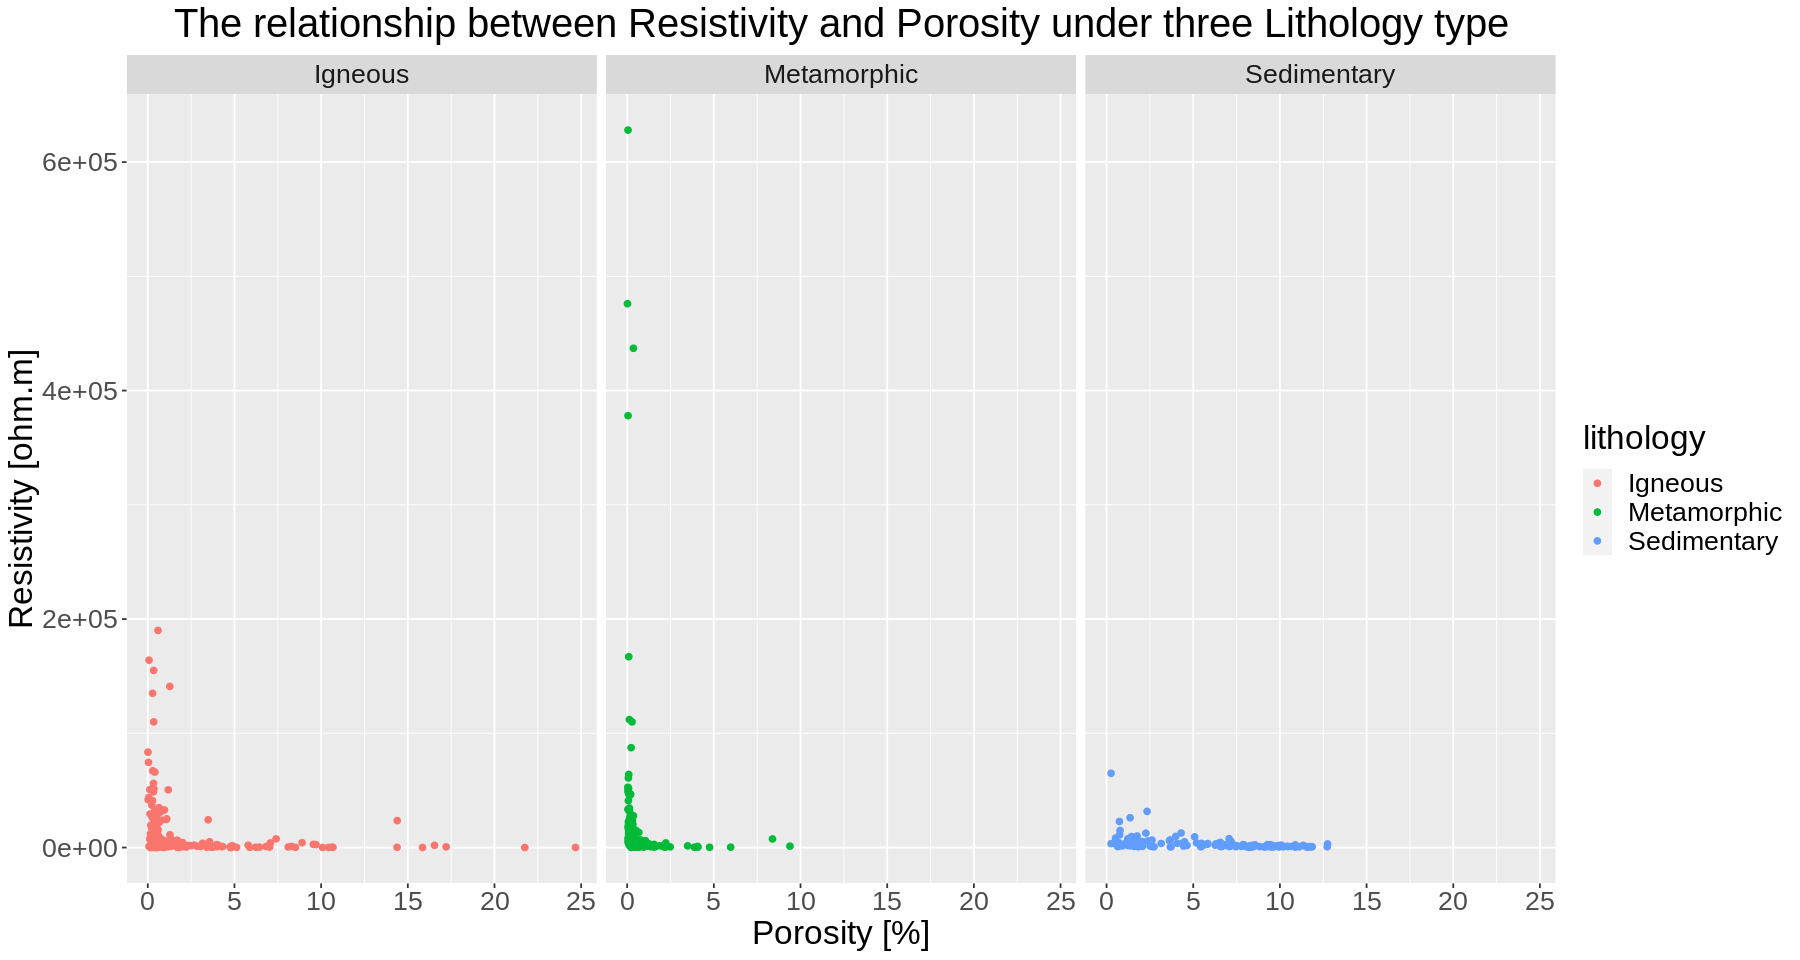

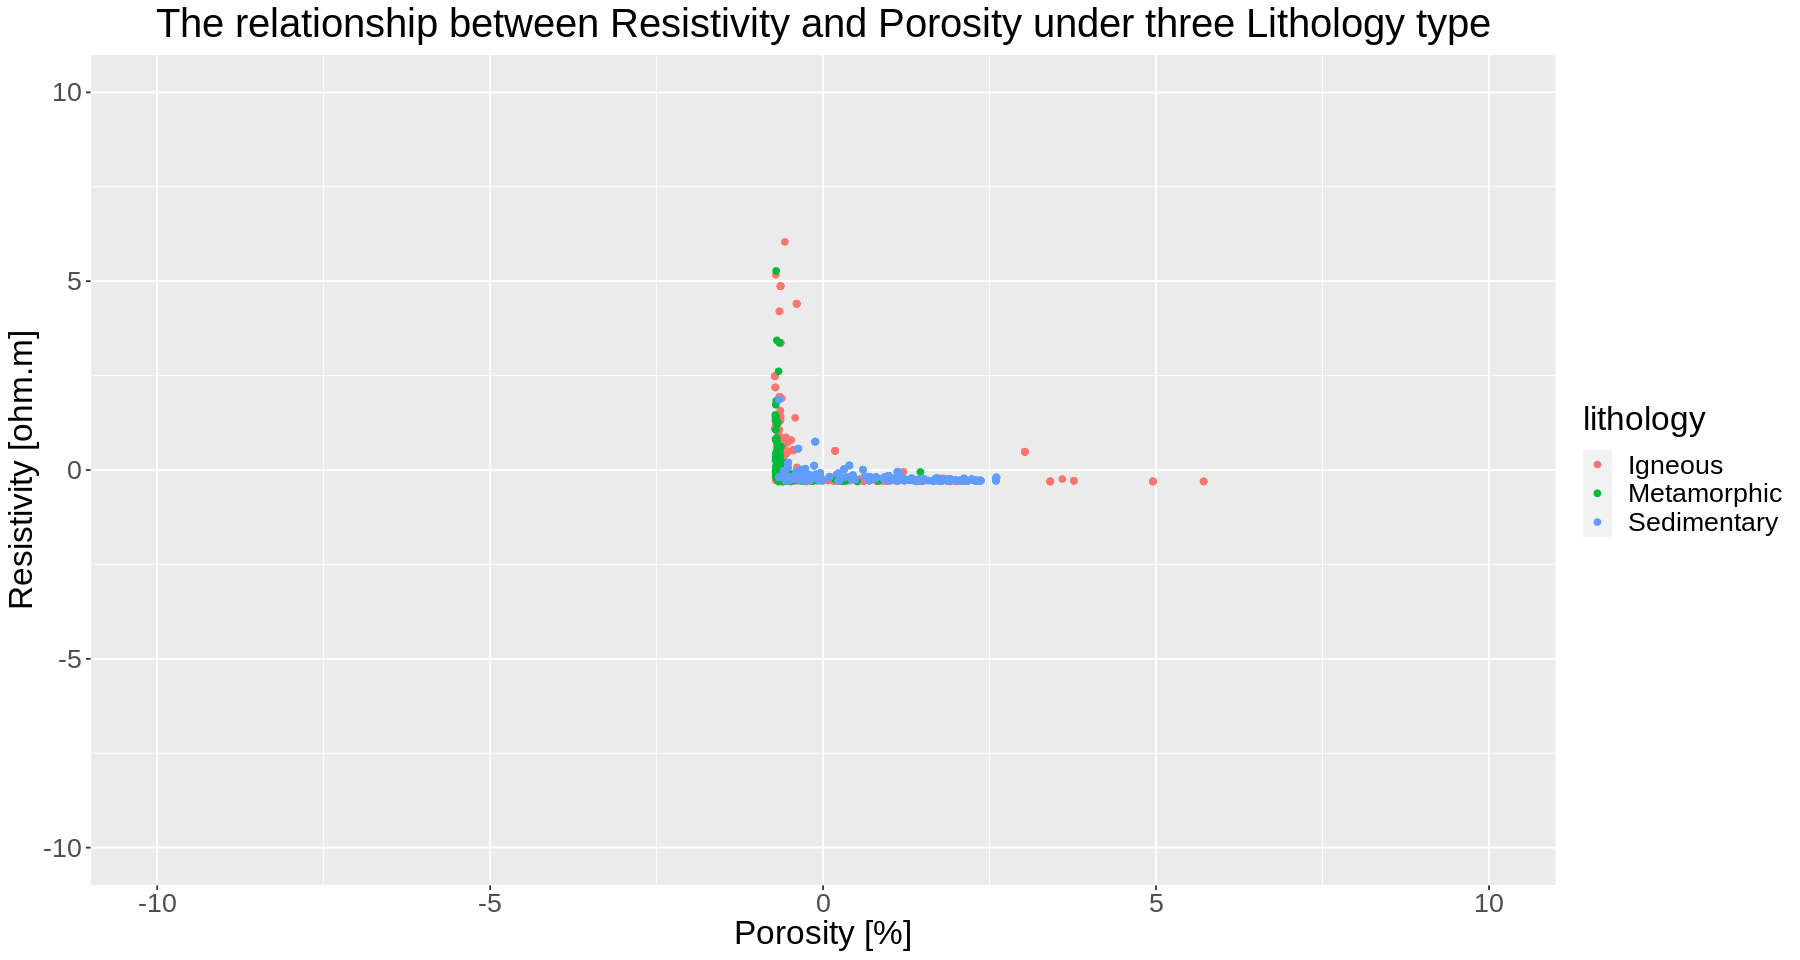

In [9]:
options(repr.plot.width = 15, repr.plot.height = 8)
initial_graph <- data_train %>%
#     ggplot(aes(x = porosity, y = RES, color = lithology)) +
#      scale_x_log10(labels = comma) +
#      scale_y_log10(labels = comma) +
#    ggplot(aes(x = log(porosity), y = log(RES), color = lithology)) +
   ggplot(aes(x = porosity, y = RES, color = lithology)) +
    geom_point() +
    facet_grid(. ~ lithology) +
    labs(title = "The relationship between Resistivity and Porosity under three Lithology type", x = "Porosity [%]", y = "Resistivity [ohm.m]") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

initial_graph

na.omit(training_data_good_to_go)



current_graph <- training_data_good_to_go %>%
     ggplot(aes(x = porosity, y = RES, color = lithology)) +
#    ggplot(aes(x = log(porosity), y = log(RES), color = lithology)) +
     scale_x_continuous(limits = c(-10, 10)) + 
     scale_y_continuous(limits = c(-10, 10)) + 
#      scale_x_log10(labels = comma) +
#      scale_y_log10(labels = comma) +
    geom_point() +
#     facet_grid(. ~ lithology) +
    labs(title = "The relationship between Resistivity and Porosity under three Lithology type", x = "Porosity [%]", y = "Resistivity [ohm.m]") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

current_graph 
# there are porosity value smaller than 1, thus the log function returns a negative value.

### Methodology
From the 84 columns in the raw data, we select and rename the 8 columns we need. They are: sample type, lithology, grain density, dry bulk density, saturated bulk density, porosity, magnetic susceptibility, natural remanent magnetization, electric resistivity and induced polarization chargeability.  
 
Since Sample type and lithology are categorical variables, we mutate their column type into factor. We then filter the data and only keep the ones with “borehole” sample type and exclude the observation with no specific rock type ("Other"). We split the data into training sets and testing sets and perform an initial analysis on the training set.  
  
The group predicted that resistivity is inversely related to porosity, because the fluid that fills in the pores is generally more conductive than rock itself. The group also want to see if porosity and resistivity alone are sufficient to predict the rock type.  
  

### Preliminary Result 
  
We observed that there is a linear relationship because the points on the scatterplot resemble close to a straight line. The two variables have a weak negative association when the lithology is Igneous because the points are more spread across the graph. There is a moderately strong negative association in the graph for Metamorphic and Sedimentary because as the percentage of Porosity increases, the Resistivity decreases.

The primary data analysis confirmed that there is a weak negative linear relationship between the two factors. However, in the primary visualization, the classification of rock types based on only these two factors are not as distinctive as we imagined.   
  
The group will continue the model building with other necessary steps including standardization or add multiple predictors into the training set in the next step of the project development.   
  
If successful, our model can be used to predict rock formation in an underground setting where human accessibility is limited and only accessible by data acquisition equipment.  
  



### References
Enkin, R.J., 2018. Canadian rock physical property database: first public release; Geological Survey of Canada, Open File 8460, 1 .zip file. https://doi.org/10.4095/313389

